In [267]:
import numpy as np
import pandas as pd
import time as ti
import math as ma
import random as rn
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [268]:
def MakeGrid(n, p):
    return np.random.binomial(1, p, (n, n))

# Algorithm
Start at the "top" row and try to get to the bottom
1. Move alone the "top" row until an actice node is found, represented by a 1.
2. Look at the adjacent squares in the following order: down, right, left, up.
    3. If you move, change the 1 on the active node to 2, 3, 4 or 5 depending on if you moved down, right, left or up.
        4. This tracks the path taken to allow for backtracking if a dead-end is found.
    5. If you dont move, go back to the place you were.
        6. If you move back and are now on the "top" row, change the current node to inactive and move to the next active node on the "top" row.
3. Repeat until you reach the other side or you reach the end of the "top" row

In [269]:
MoveBack = dict([(2, np.array([-1, 0])), (3, np.array([0, -1])), (4, np.array([0, 1])), (5, np.array([1, 0]))])

In [270]:
def SolveGrid(Grid):
    Size = len(Grid)
    CurrentPosition = np.array([0,0])
    CurrentHomeRow = 0

    if sum(Grid[0]) > 0:
        while Grid[0, CurrentHomeRow] == 0:
            CurrentHomeRow += 1
        CurrentPosition = [0, CurrentHomeRow]
            
        while CurrentPosition[0] != Size - 1:
            x = CurrentPosition[1]
            y = CurrentPosition[0]
            Moved = False

            #down
            if Grid[y+1][x] == 1:
                y += 1
                Moved = True
                Grid[y][x] = 2
            #right   
            if not Moved:
                    if x != Size - 1:
                        if Grid[y][x+1] == 1:
                            x += 1
                            Moved = True
                            Grid[y][x] = 3
            #left             
            if not Moved:   
                if x != 0:
                    if Grid[y][x-1] == 1:
                            x -= 1
                            Moved = True
                            Grid[y][x] = 4
            #up              
            if not Moved:    
                if y > 0:
                    if Grid[y-1][x] == 1:
                            y -= 1
                            Moved = True
                            Grid[y][x] = 5


            CurrentPosition = [y,x]
            
            if Moved == False:  
                if CurrentPosition[0] != 0:
                    CurrentPosition += MoveBack[Grid[y][x]]
                    Grid[y][x] = 0
                if CurrentPosition[0] == 0:
                #Path found from which. Grid > 1 https://stackoverflow.com/questions/16094563/numpy-get-index-where-value-is-true
                #Requires us to reset all the non binary cells when we move along bottom row. This will be done right HERE. 
                    Grid[y][x] = 0

                    CurrentHomeRow = CurrentPosition[1] + 1
                    if sum(Grid[0][CurrentHomeRow:]) > 0:
                        while Grid[0, CurrentHomeRow] == 0:
                            CurrentHomeRow += 1
                        CurrentPosition = [0, CurrentHomeRow]
                    else:       
                        return 0
                        break   
            if CurrentPosition[0] == Size - 1:

                return 1
                break
    else:
        return 0

# Time contribition of grid generation and solver
Investigate how the solver time is affected by the grid population.

In [340]:
runs_per = 100
grid_size = 500
smallest_prob = 0#0.59
largest_prob = 1 #.60
total_points = 500

grid_times = []
solve_times = []

success = []
for probability in np.linspace(smallest_prob, largest_prob, total_points):
    current = 0
    grid_time = 0
    solve_time = 0
    total_start = ti.time()
    for runs in range(0,runs_per):
        start = ti.time()
        test = MakeGrid(grid_size, probability)
        grid_time += ti.time() - start
        
        start = ti.time()
        current += SolveGrid(test)
        solve_time += ti.time() - start
        
    grid_times.append(grid_time)
    solve_times.append(solve_time)
    success.append([probability, current/runs_per, ti.time() - total_start])
round(sum(grid_times) + sum(solve_times), 5)

474.52875

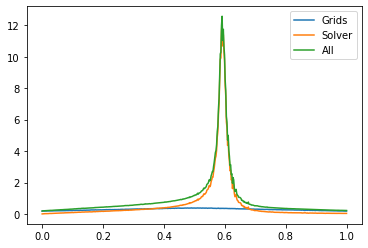

In [342]:
plt.plot(np.linspace(smallest_prob, largest_prob, total_points), grid_times, label = "Grids")
plt.plot(np.linspace(smallest_prob, largest_prob, total_points), solve_times, label = "Solver")
plt.plot(np.linspace(smallest_prob, largest_prob, total_points), [x + y for x, y in zip(grid_times, solve_times)], label = "All")
plt.legend()

The image above illustrates that the solver is responsible for effectively all computation time. Crucially, the computation time increased enormously around the critical percolation probability $$p = p_c \sim 0.59$$

# Binary Behavior
Investigate how the lattice exhibits binary behaviour as the lattice size is increased. As the lattice size $\to \infty$, the system tends to be entirely binary. Above $p = p_c$, the maze is solvable. Below $p_c$, the maze is not solvable.

In [7]:
def TestRun(runs_per = 100, grid_size = 100, probability = 0.58):
    success = []
    current = 0
    start = ti.time()
    for runs in range(0,runs_per):
        test = MakeGrid(grid_size, probability)
        current += SolveGrid(test)
    success.append([probability, current/runs_per])#, ti.time() - start])
    return success

In [6]:
def Final(p):#100 was 124 # 400 was 1350
    return TestRun(runs_per = 5000, grid_size = 100, probability = p)

In [7]:
starter = ti.time()
element_run = Parallel(n_jobs=4)(delayed(Final)(k) for k in np.linspace(0, 1, 101))
print(ti.time() - starter)

108.6390597820282


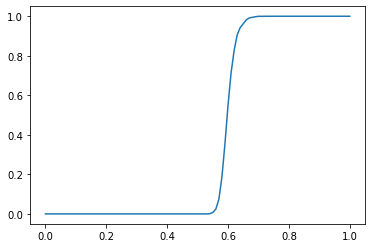

In [8]:
plt.plot([x[0][0] for x in element_run], [x[0][1] for x in element_run])

# Algo for $p_c$
This is a simple algorithm that leverages the bisection method where a range of probabilities are sampled with the range halving in size over each iteration of the algorithm.

In [21]:
upper = .7
lower = .4
goes = 10
start = ti.time()
gridsize = 10000
while goes > 0:
    guess = (upper + lower)/2
    if SolveGrid(MakeGrid(gridsize, guess)): 
        upper = guess
    else:
        lower = guess
    goes -= 1
    print((upper + lower)/2)
    gridsize += 2000
ti.time() - start 

0.625
0.5875
0.60625
0.596875
0.5921875000000001
0.5945312500000001
0.5933593750000001
0.5927734375000001
0.5930664062500002
0.5929199218750001


1118.407900094986